In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import librosa
from librosa import display
import pyaudio as pa
import wave
from scipy import signal
from scipy import fftpack

In [3]:
wav, f = librosa.load("./exp_chunks/raw.wav", sr = 22050)
print(len(wav))
print(f)
print(len(wav)/f)
print(type(wav))
print(wav.shape)

5675560
22050
257.3950113378685
<class 'numpy.ndarray'>
(5675560,)


In [2]:
def plotWav(wav, f, ratio, start, end, title, mode='t'):
    width, height = figaspect(ratio)
    fig = figure(figsize=(width,height))
    
    if mode == 't': #time
        startI = start * f
        endI = end * f
        Idx = np.arange(startI, endI)
        chunk = wav[startI : endI]
        plot(Idx, chunk)
        plt.title(title)
        return chunk
    elif mode == 'i': # index
#         startSec = start / f
#         endSec = end / f
#         secIdx = np.arange(startSec, endSec, 1/f)
        Idx = np.arange(start, end)
        chunk = wav[start : end]
        plot(Idx, chunk)
        plt.title(title)
        return chunk

In [3]:
import struct

def decodePCM(rawData):
    npts=len(rawData)                     
    formatstr='%dh' % (npts/2)                
    int_data=struct.unpack(formatstr,rawData) 
    f_data = np.array([float(val) / pow(2, 15) for val in int_data])
    return f_data

# f = decodePCM(data)

## Experiment for multi-threading

In [2]:
import threading
import math
from queue import Queue


frames = []


def barData(data_freq):
    bar_len = 5
    length = math.ceil(data_freq.shape[0] / bar_len)
    data_bar = np.empty(length)
    for i in range(length):
        if data_freq.shape[0] < (i+1)*bar_len:
            data_bar[i] = np.mean(data_freq[bar_len*i : ])
        else:
            data_bar[i] = np.mean(data_freq[bar_len*i : bar_len*(i+1)])
    return data_bar

def consumChunk(in_q):
    """
    fixed-size spectrum display
    fixed-size bar number: 100?
    """
#     n_iter = in_q.get()
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     line1, = ax.plot(x, y, 'r-')
#     for i in range(n_iter):
    while 1:
#         if in_q.get() == None:
        data_freq = fftpack.fft(decodePCM(in_q.get()))
        length = math.floor(data_freq.shape[0]/2) + 1
        
        data_bar = barData(data_freq[:length])
        
        freq_idx = np.r_[:data_bar.shape[0]]
        plt.bar(freq_idx, data_bar)
        plt.show()    
    
def produceChunk(out_q, chunk, rate, time, filename):
    CHUNK = chunk
    FORMAT = pa.paInt16
    CHANNELS = 1
    RATE = rate
    RECORD_SECONDS = time
    WAVE_OUTPUT_FILENAME = filename

    p = pa.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    
    print("* recording")
    
    n_iter = int(RATE / CHUNK * RECORD_SECONDS)
#     out_q.put(n_iter)
    for i in range(0, n_iter):
        data = stream.read(CHUNK)
        out_q.put(data)
        frames.append(data)
         
    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    
#     ex_samWid = wf._sampwidth
    
    wf.close()
    
#     result.put(frames)
    


def record(filename, time = 5, rate = 22050, chunk = 1024):
    
    q = Queue()
    result = Queue()
    
    t1 = threading.Thread(target=produceChunk, args=(q, chunk, rate, time, filename)) 
    t2 = threading.Thread(target=consumChunk, args=(q,)) 
        
    t1.start()
    t2.start()
    
    t1.join()
    t2.join()
    






## record function you can rely on

In [ ]:
def record(filename, time = 5, rate = 22050, chunk = 1024):
    CHUNK = chunk
    FORMAT = pa.paInt16
    CHANNELS = 1
    RATE = rate
    RECORD_SECONDS = time
    WAVE_OUTPUT_FILENAME = filename

    p = pa.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []
    
        
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
        
        
    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))    
    wf.close()

In [3]:
record("./static_dis.wav", time = 5)


* recording
* done recording


## Code below proves that only builtin python file.write change the data
so our goal is how we gonna convert the unchanged data to readable data.
the key is to know how the same level data when reading is handled.

In [144]:
#  import builtins   
def getFrameData(data, sampwidth, nchannels):
    if not isinstance(data, (bytes, bytearray)):
        data = memoryview(data).cast('B')
    nframes = len(data) // (sampwidth * nchannels)
    if sampwidth != 1 and sys.byteorder == 'big':
        data = audioop.byteswap(data, sampwidth)
    return data

data = getFrameData(b''.join(frames), sampwidth = ex_samWid, nchannels = 1)
len(data)

220000

In [27]:
frames, ex_samWid = record("./exp.wav", time = 2)

* recording
* done recording


In [111]:
print(frames)

[b'\xfe\xff\x01\x00\xec\xffn\xffW\xff\x97\xff\xef\xff\xb5\x00\x9d\x00\xc8\xffN\x00\xf8\xff\x86\xfe~\xfeK\xfe\xe4\xfe\x98\x01\x0c\x04\xf1\x04\x98\x05\x7f\x04\xf7\x01\xee\x00m\xfd\x14\xfa\x84\xfa\xb7\xfa\x15\xfd\x16\x00\x05\x01\xb5\x02\xa4\x03\xf2\x03\x8a\x03\xc6\x02 \x03\x8b\x01F\x00\x00\x01G\x00\xdd\xff\xd0\xff{\xfe|\xfc\xa1\xfb\x9d\xfd\xa9\xff\xdf\x01\xce\x02\x91\x01\xc4\x02\x86\x03\xc6\x01\x8f\xfe;\xfb\xf7\xfaa\xfcw\xfei\x001\x02s\x05\x19\x08\x8f\x08\x89\x06\x06\x03\xa4\xff\xa5\xfbh\xf8\x8f\xf6j\xf6\x10\xfb\xcc\xff\x81\x00\x9b\x01}\x02\x97\x02\xf1\x03\\\x03=\x00\xd7\xfe\x90\xff\xea\xff\x1b\x00\xfa\xff\xfb\xfe\x8a\xfe\xa4\xfe\x0b\xfe\xf9\xfc\x1f\xfd=\xfe]\xff\xe0\x01\xee\x03\xe0\x03|\x04\xa3\x039\x01%\x00\xf7\xfc8\xfa\xa1\xfa\x18\xfb\xb9\xfc\xcf\xfe\xc8\xff\xcb\x00\x90\x02e\x03\x10\x02\xaa\x01#\x026\x01\x93\x00\x8e\x00e\x00O\x00\x84\xff\x10\xfd\xa5\xfa\xab\xfb\xf1\xfdc\xff-\x01\x0e\x01\n\x01D\x02\xa6\x01\xa3\xffc\xfc{\xfa\xad\xfa\xe6\xfb\x9c\xfe<\x00\x83\x02\xce\x05\xaf\x06@\x06\x19\x

In [118]:
wav_,f_ = librosa.load("./test_short.wav", sr = None)

In [142]:
np.set_printoptions(threshold=sys.maxsize)
print(wav_)

[-2.19726562e-03 -2.04467773e-03 -6.10351562e-05  1.80053711e-03
  3.11279297e-03  3.72314453e-03  2.83813477e-03  8.85009766e-04
 -8.23974609e-04 -2.19726562e-03 -3.11279297e-03 -3.08227539e-03
 -2.28881836e-03 -1.28173828e-03 -6.10351562e-05  1.22070312e-03
  2.04467773e-03  2.10571289e-03  1.83105469e-03  1.12915039e-03
 -6.10351562e-05 -1.34277344e-03 -2.31933594e-03 -2.83813477e-03
 -2.53295898e-03 -1.25122070e-03  4.27246094e-04  2.04467773e-03
  3.29589844e-03  3.44848633e-03  2.44140625e-03  9.46044922e-04
 -2.74658203e-04 -1.31225586e-03 -1.77001953e-03 -1.61743164e-03
 -1.06811523e-03 -5.18798828e-04  3.05175781e-05  5.49316406e-04
  7.93457031e-04  4.88281250e-04 -3.35693359e-04 -8.54492188e-04
 -8.23974609e-04 -7.01904297e-04 -3.96728516e-04  1.52587891e-04
  3.05175781e-04 -2.74658203e-04 -6.10351562e-04 -3.35693359e-04
  0.00000000e+00  4.27246094e-04  1.15966797e-03  1.52587891e-03
  1.12915039e-03  3.35693359e-04 -3.96728516e-04 -9.76562500e-04
 -1.06811523e-03 -6.40869

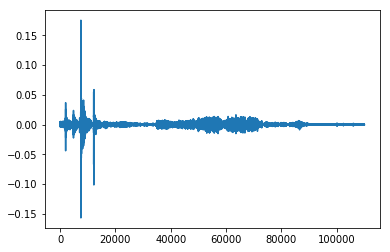

In [143]:
plot(wav_)

In [4]:
wav_, f_ = librosa.load("./exp_chunks/output.wav", sr = None)
print(len(wav_))
print(f_)

1321984
22050


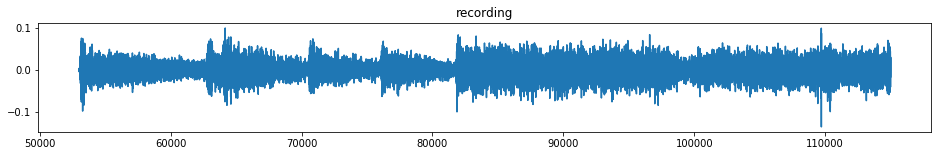

In [7]:
chunk_rec = plotWav(wav_, f_, 0.1, 53000, 115000, "recording", 'i')
# plotWav(wav_, f_, 0.1, 2, 3, "recording")
# for time idx: 2-3
# 50000 - 65000
# 53000-54000
#53000-53200

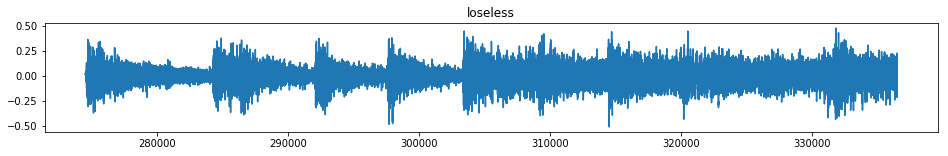

In [8]:
# plotWav(wav, f, 0.1, 12, 13, "loseless")
chunk_loseless = plotWav(wav, f, 0.1, 274520, 336520, "loseless", 'i')
# for time idx: 12-13
#274520-274720

In [16]:
import sys
import scipy.io.wavfile as sciwavf

def storeChunk(filename, chunk, f):
    sciwavf.write(filename, f, chunk)
    
# def playChunk(filename):
#     CHUNK = 1024
    
#     wf = wave.open(filename, 'rb')
    
#     print(type(wf))

#     p = pa.PyAudio()

#     stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
#                     channels=wf.getnchannels(),
#                     rate=wf.getframerate(),
#                     output=True)
    
    

#     data = wf.readframes(CHUNK)

#     while data != '':
#         stream.write(data)
#         data = wf.readframes(CHUNK)

#     stream.stop_stream()
#     stream.close()

#     p.terminate()

def playChunk(filename):
    CHUNK = 1024
    
    wf = wave.open(filename, 'rb')

    p = pa.PyAudio()

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    
    

    data = wf.readframes(CHUNK)

    while data != '':
        stream.write(data)
        data = wf.readframes(CHUNK)
        print(type(data))

    stream.stop_stream()
    stream.close()

    p.terminate()

In [17]:
# wav, f = librosa.load("./exp_chunks/raw.wav", sr = 22050)

playChunk("./exp_chunks/raw.wav")

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

KeyboardInterrupt: 

In [10]:
# storeChunk("recording1.wav", wav_, f_)

In [6]:
# storeChunk("chunk_rec_2.wav", wav_, f_)
# storeChunk("chunk_losless_2.wav", wav[274520-53000:336520+1206984], f)

In [12]:
from scipy.fftpack import fft,fftshift
from scipy.signal import stft
# f = fftshift(fft(chunk_loseless))
# f_ = fftshift(fft(chunk_rec))
f = fft(wav[274520:1543504])
f_ = fft(wav_[53000:1321984])

/Users/zhouhang/anaconda3/envs/song-recong/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'recording')

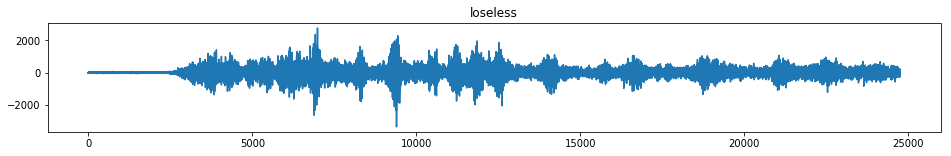

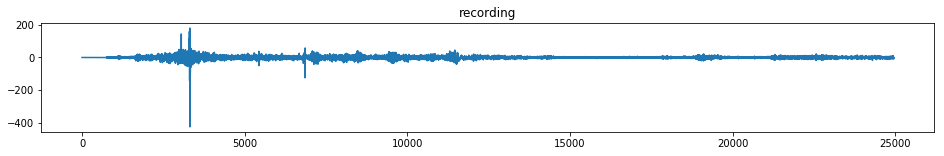

In [13]:
width, height = figaspect(0.1)
fig1 = figure(figsize=(width,height))
# plot(np.r_[250:25000],f[250:25000])
plot(f[250:25000])
plt.title("loseless")
fig2 = figure(figsize = (width, height))
# plot(np.r_[50:25000],f_[50:25000])
plot(f_[50:25000])
plt.title("recording")

Text(0.5,1,'lossless')

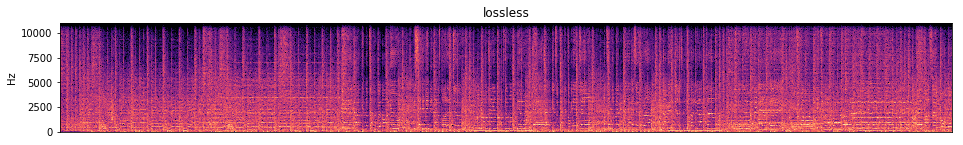

In [14]:
# fa, t, Zxx = signal.stft(chunk_loseless, f, nperseg=1000)
# plt.pcolormesh(t, fa, np.abs(Zxx))
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav[274520:1543504])), ref=np.max)
width, height = figaspect(0.1)
fig1 = figure(figsize=(width,height))
librosa.display.specshow(D, y_axis='linear')
plt.title("lossless")

Text(0.5,1,'rec')

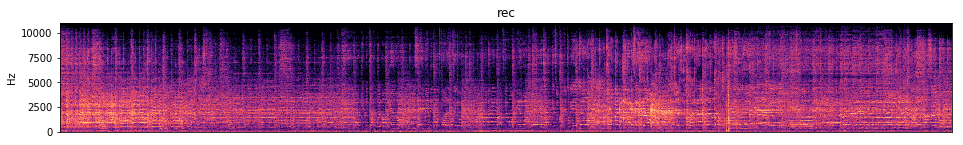

In [15]:
D_ = librosa.amplitude_to_db(np.abs(librosa.stft(wav_[53000:1321984])), ref=np.max)
width, height = figaspect(0.1)
fig2 = figure(figsize=(width,height))
librosa.display.specshow(D_, y_axis='linear')
plt.title("rec")

## Another method to present the spectrum

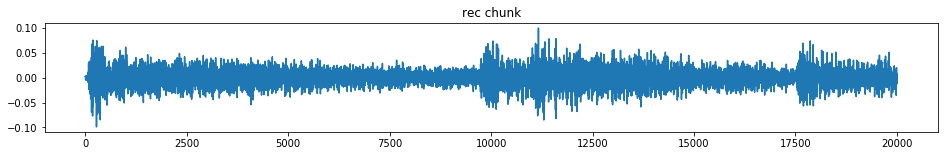

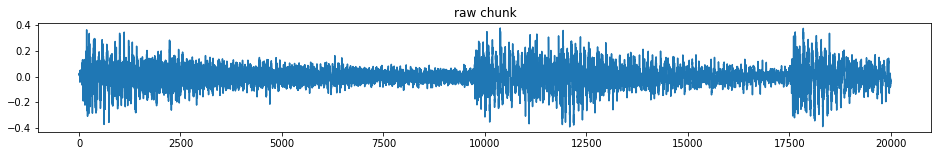

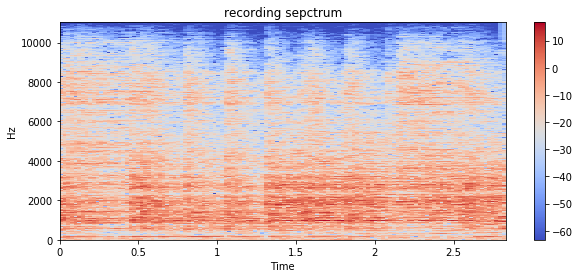

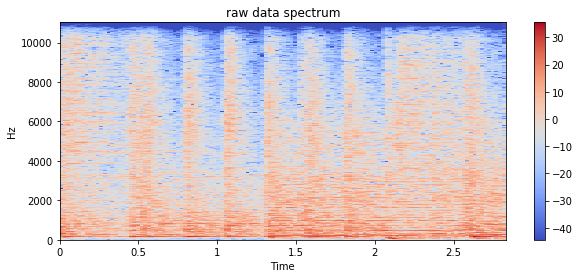

In [16]:
def plotSpect(specdb, ratio, title):
    width, height = figaspect(ratio)
    fig = figure(figsize=(width,height))
    
    librosa.display.specshow(specdb, sr = 22050, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)
    
wav_rec, f_rec = librosa.load("./exp_chunks/chunk_rec_1.wav", sr = 22050)
wav_raw, f_raw = librosa.load("./exp_chunks/chunk_losless_1.wav", sr = 22050)
plotWav(wav_rec, f_rec, 0.1, 0, 20000, "rec chunk", 'i')
plotWav(wav_raw, f_raw, 0.1, 0, 20000, "raw chunk", 'i')


rec_db = librosa.amplitude_to_db(abs(librosa.stft(wav_rec)))
raw_db = librosa.amplitude_to_db(abs(librosa.stft(wav_raw)))
plotSpect(rec_db, 0.4, "recording sepctrum")
plotSpect(raw_db, 0.4, "raw data spectrum")

## Realtime Music Spectrum Bar